### (NDP) Node Design Problem
- Minimize the total fixed charges and transportation cost.
- Sets:
    - $I$: set of customers locations
    - $J$: set of candidate facility locations
    - $K$: set of candidate distribution center locations
    - $L$: set of products
- Parameters:
    - $h_{il}$: (annual) demand of customer $i\in I$ for product $l\in L$
    - $v_j$: capacity of distribution center $j\in J$
    - $b_k$: capacity of plant $k\in K$
    - $s_l$: units of capacity of plant $\in K$
    - $f_j$: fixed (annual) cost to open a distribution center at site $l\in L$
    - $g_k$: fixed (annual) cost to open a plant at site $k\in K$
    - $c_{ijk}$: cost to transport 1 unit of product $l\in L$ from distribution center at $j$ to customer $i$
    - $d_{jkl}$: cost to transport 1 unit of product $l\in L$ from plant at $k$ to distribution center at $j$
- Decision variables:
    - $x_j=\begin{cases}1, \quad\text{if a distribution center is opened at } j\in J\\0, \quad\text{O.W.}\end{cases}$
    - $z_k=\begin{cases}1, \quad\text{if a plant is opened at } k\in K\\0, \quad\text{O.W.}\end{cases}$
    - $y_{ijl}=\text{the number of units of product }l\in L\text{ shipped from distribution center at }j\text{ to customer }i$
    - $w_{jkl}=\text{the number of units of product }l\in L\text{ shipped from plant at }k\text{ to distribution center at }j$

<br>

$$
\begin{split}
\text{(NDP)}\quad & \text{minimize}\quad \sum\limits_{j\in J}f_{j}x_{j} + \sum\limits_{k\in K}g_{k}z_{k} + \sum\limits_{l\in L}(\sum\limits_{j\in J}\sum\limits_{i\in I}c_{ijl}y_{ijl} + \sum\limits_{k\in K}\sum\limits_{j\in J}d_{jkl}w_{jkl})\\
&\begin{split}
\text{subject to}\quad\quad &\sum\limits_{j\in J}y_{ijl} = h_{il}                  &\forall i\in I, \forall l\in L\\
    &\sum\limits_{i\in I}\sum\limits_{l\in L}s_{l} y_{ijl} \le v_{j}x_{j}          &\forall j\in J\\
    &\sum\limits_{k\in K}w_{jkl}=\sum\limits_{i\in I}y_{ijl}                       &\forall j\in J, \forall l\in L\\
    &\sum\limits_{j\in J}\sum\limits_{l\in L}s_{l}w_{jkl} \le b_{k}z_{k}\quad\quad &\forall k\in K\\
    &x_{j}, z_{k}\in \{0, 1\} &\forall j\in J, \forall k\in K\\
    &y_{ijl}, w_{jkl}\ge 0    &\forall i\in I, \forall j\in J, \forall k\in K, \forall l\in L\\ 
\end{split}
\end{split}
$$

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.lines import Line2D
from scipy import stats
from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

In [3]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
j_data = pd.read_excel('data.xlsx', sheet_name='j_data')
k_data = pd.read_excel('data.xlsx', sheet_name='k_data')
l_data = pd.read_excel('data.xlsx', sheet_name='l_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values
dist_jk = pd.read_excel('data.xlsx', sheet_name='dist_jk').values

In [4]:
# declare the parameters and sets
h = i_data[[f'Demand_{i}' for i in range(5)]].values
v = j_data['Capacity'].values
b = k_data['Capacity'].values
s = l_data['Capacity Consumed'].values
f = j_data['Fixed Charge'].values
g = k_data['Fixed Charge'].values

I = [i for i in range(len(i_data['X']))]
J = [j for j in range(len(v))]
K = [k for k in range(len(b))]
L = [j for j in range(len(s))]

IJL = [(i, j, l) for i in I for j in J for l in L]
JKL = [(j, k, l) for j in J for k in K for l in L]

c = {(i, j, l): dist_ij[i, j] * s[l] for i, j, l in IJL}
d = {(j, k, l): dist_jk[j, k] * s[l] for j, k, l in JKL}

In [5]:
# create model
mdl = Model('NDP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [6]:
# add model variables
x = mdl.addVars(J, vtype=GRB.BINARY)
z = mdl.addVars(K, vtype=GRB.BINARY)

y = mdl.addVars(IJL)
w = mdl.addVars(JKL)

In [7]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(
    quicksum(f[j]*x[j] for j in J) +
    quicksum(g[k]*z[k] for k in K) +
    quicksum(c[i,j,l]*y[i,j,l] for i,j,l in IJL) +
    quicksum(d[j,k,l]*w[j,k,l] for j,k,l in JKL)
)

In [8]:
# add the model constraints
mdl.addConstrs(quicksum(y[i,j,l] for j in J) == h[i,l] for i in I for l in L)
mdl.addConstrs(quicksum(s[l]*y[i,j,l] for i in I for l in L) <= v[j]*x[j] for j in J)
mdl.addConstrs(quicksum(w[j,k,l] for k in K) == quicksum(y[i,j,l] for i in I) for j in J for l in L)
mdl.addConstrs(quicksum(s[l]*w[j,k,l] for j in J for l in L) <= b[k]*z[k] for k in K)
mdl.addConstrs(y[i,j,l] >= 0 for i,j,l in IJL)
mdl.addConstrs(w[j,k,l] >= 0 for j,k,l in JKL)
mdl.update()

In [9]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 11125 rows, 10525 columns and 41525 nonzeros
Model fingerprint: 0xb59a2f49
Variable types: 10500 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+03]
  Objective range  [4e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 747458.01386
Presolve removed 10758 rows and 5160 columns
Presolve time: 0.02s
Presolved: 367 rows, 5365 columns, 15545 nonzeros
Variable types: 5340 continuous, 25 integer (25 binary)

Root relaxation: objective 2.332220e+05, 412 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 233222.032    0   19 747458.014 233222.032  68.8%     -    0s
H    0     0                    32

In [10]:
# update the dataframes
j_data['Opened'] = [int(x[j].X > 0.0) for j in J]
k_data['Opened'] = [int(z[k].X > 0.0) for k in K]

Text(0.5, 1.0, 'Plants and Distribution Centers Chosen')

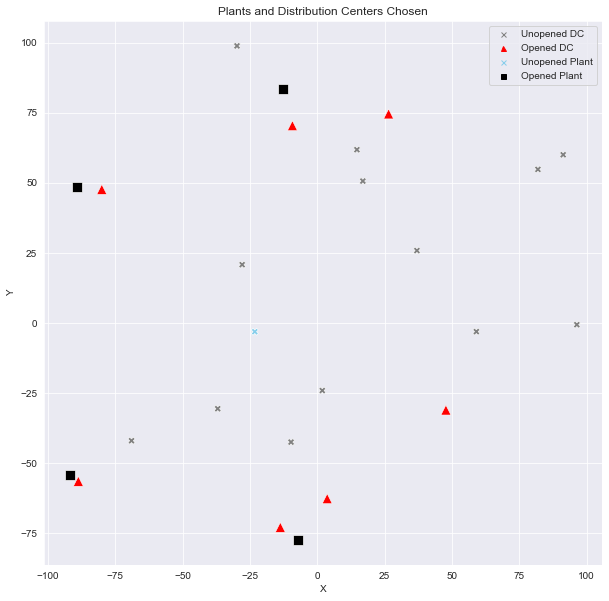

In [11]:
# plot the station locations
fig, ax = plt.subplots(figsize=(10,10))
s1 = [100 if i == 1 else 50 for i in j_data['Opened'].values]
s2 = [100 if i == 1 else 50 for i in k_data['Opened'].values]
sns.scatterplot(x='X', y='Y', data=j_data, hue='Opened', palette=['grey', 'red'], style='Opened', markers=('X', '^'), s=s1)
sns.scatterplot(x='X', y='Y', data=k_data, hue='Opened', palette=['skyblue', 'black'], style='Opened', markers=('X', 's'), s=s2)

legend_elements = [
    Line2D([0], [0], marker='x', lw=0, color='grey', label='Unopened DC', markerfacecolor='grey', markersize=5),
    Line2D([0], [0], marker='^', lw=0, color='red', label='Opened DC', markerfacecolor='red', markersize=5),
    Line2D([0], [0], marker='x', lw=0, color='skyblue', label='Unopened Plant', markerfacecolor='skyblue', markersize=5),
    Line2D([0], [0], marker='s', lw=0, color='black', label='Opened Plant', markerfacecolor='black', markersize=5)
]

ax.legend(handles=legend_elements)
plt.title('Plants and Distribution Centers Chosen')

Text(0.5, 1.0, 'Plant and Distribution Center Coverage')

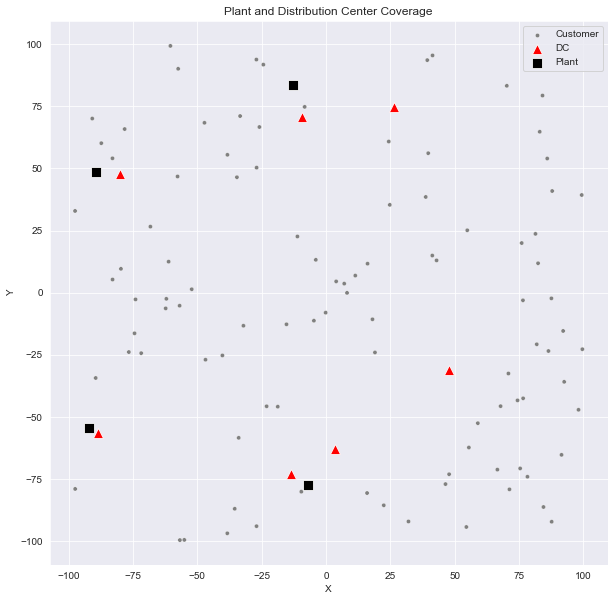

In [12]:
# plot the customer coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=i_data, size=1, color='grey', legend=False, label="Customer")
sns.scatterplot(x='X', y='Y', data=j_data[j_data['Opened'] == 1], s=100, color='red', marker='^', label="DC")
sns.scatterplot(x='X', y='Y', data=k_data[k_data['Opened'] == 1], s=100, color='black', marker='s', label="Plant")
plt.title('Plant and Distribution Center Coverage')

In [13]:
# find objective value
fac_cost = sum([f[j]*x[j].X for j in J])
plant_cost = sum(g[k]*z[k].X for k in K)
trans_cost1 = sum(c[i,j,l]*y[i,j,l].X for i,j,l in IJL)
trans_cost2 = sum(d[j,k,l]*w[j,k,l].X for j,k,l in JKL)
obj_val = fac_cost + plant_cost + trans_cost1 + trans_cost1

print('Distribution center cost = ', fac_cost)
print('Plant cost = ', plant_cost)
print('Transportation cost = ', trans_cost1 + trans_cost2)
print('Objective value = ', obj_val)

Distribution center cost =  50842.063804984646
Plant cost =  31161.40109703781
Transportation cost =  185114.09345712562
Objective value =  333923.01296390954
